# Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from plot import plot_action_value, policyTrajectory

# Random Seed

In [2]:
np.random.seed(111)
random.seed(111)

# Grid Environment

In [3]:
class GridWorld():

    """
    This is a 5 by 5 grid where an agent starts at the blue square and move to a neighboring state
    with equal probability. If the agent moves to a red state, it will receive a reward of -20 and 
    go back to the start, i.e., the blue state. A move between any two other states receives a reward 
    of -1. A move that attempts to move outside the grid receives a reward of -1. The black squares
    serve as terminal states.

    if count starts from 0, such that position (0, 3) means row 0 and column 3. The position of the 
    colored squares are as follow:
    blue square = (4, 0);
    red squares = (2, 0), (2, 1), (2, 3), (2, 4);
    black squares = (0, 0), (0, 4)

    """

    # parameters
    def __init__(self):

        # grid size (row, col)
        self.gridsize = (5, 5)

        # all states
        self.state_space = [(row, col) for row in range(self.gridsize[0])
                            for col in range(self.gridsize[1])]
        
        # all actions
        self.action_space = ['up', 'down', 'left', 'right']

        # effect of action on row and col
        self.action_delta = {
            'up': (-1, 0),
            'down': (1,0),
            'left': (0, -1),
            'right': (0, 1)
            } 
        
        # special states
        self.red_state = [(2, 0), (2, 1), (2, 3), (2, 4)]
        self.black_state = [(0, 0), (0, 4)]
        self.blue_state = (4, 0)

    # start state
    def reset(self):
        return self.blue_state
    
    # terminal state
    def isTerminal(self, state):
        return state in self.black_state
    
    # get next state and reward
    def nextStateReward(self, state, action):
        # red state
        if state in self.red_state:
            next_state = self.blue_state
            reward = -20
            return (next_state, reward)
        # other states
        else:
            delta = self.action_delta[action]
            next_state = (state[0] + delta[0], state[1] + delta[1])
            # check if next state is within the grid
            if 0 <= next_state[0] < self.gridsize[0] and 0 <= next_state[1] < self.gridsize[1]:
                reward = -1
                return (next_state, reward)
            else:
                reward = -1
                return(state, reward)

# sarsa (On-policy TD Control)

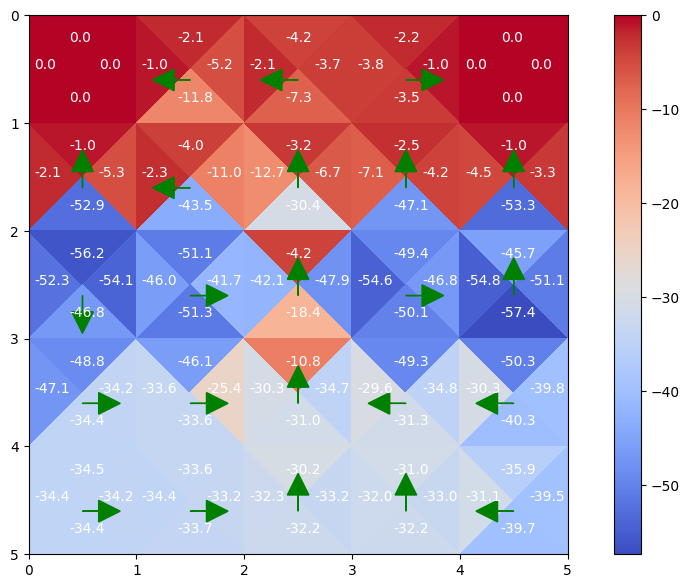

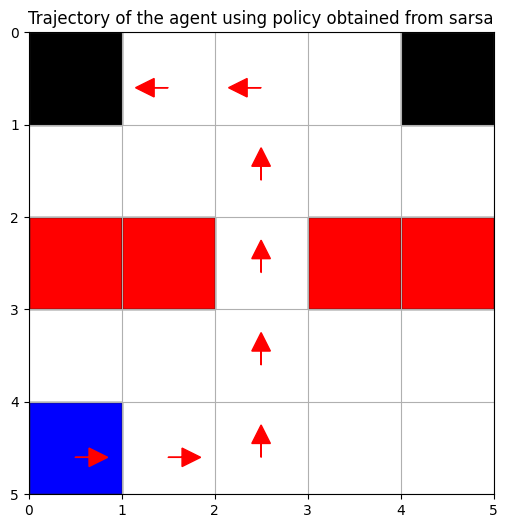

In [4]:
def sarsa(mdp, alpha, epsilon, num_episode, gamma):
    
    # initialize Q
    Q = {}
    for state in mdp.state_space:
        for action in mdp.action_space:
            if mdp.isTerminal(state):
                Q[(state, action)] = 0
            else:
                Q[(state, action)] = 10
    
    # epsilon-greedy policy
    def policy(state):
        if np.random.random() < epsilon:
            action = random.choice(mdp.action_space)
        else:
            q_values = []
            for (s, a), val in Q.items():
                if s == state:
                    q_values.append(val)
            best_action = np.argmax(q_values)
            action = mdp.action_space[best_action]
        return action
    
    # placeholder for cumulative rewards of each episode
    total_reward = []

    for _ in range(num_episode):
        start_state = mdp.reset()
        state = start_state
        action = policy(state)
        cum_reward = 0
        while True:
            next_state, reward = mdp.nextStateReward(state, action)

            # obtain next actions from next state using policy
            next_action = policy(next_state)

            # update Q
            Q[(state, action)] += round((alpha * (reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])), 1)

            # update state and action
            state = next_state
            action = next_action

            # update sum of reward
            cum_reward += reward

            if mdp.isTerminal(state):
                break
        
        total_reward.append(cum_reward)
    
    return Q, total_reward



# implement sarsa on-policy TD Control
mdp = GridWorld()
gamma = 1
alpha = 0.5
epsilon = 0.2
num_epsiode = 500000

Q, reward_sarsa = sarsa(mdp= mdp,
                  alpha= alpha,
                  epsilon= epsilon,
                  num_episode= num_epsiode,
                  gamma= gamma
                  )


# obtain optimal policy from Q
policy = np.empty(mdp.gridsize, dtype= object)
for state in mdp.state_space:
    policy[state] = []

    if not mdp.isTerminal(state):
        action_values = []
        for (s,a), v in Q.items():
            if s == state:
                action_values.append(round(v, 1))
        
        best_action = np.where(np.array(action_values) == max(action_values))[0]

        for idx in best_action:
            action = mdp.action_space[idx]
            policy[state].append(action)

    
# convert Q to grid for easy visualization
action_value_grid = np.zeros((len(mdp.state_space), len(mdp.action_space)))

for i, state in enumerate(mdp.state_space):
    for j, action in enumerate(mdp.action_space): 
        value = Q[(state, action)]
        action_value_grid[(i,j)] = value

# Visualize Q and Policy
plot_action_value(mdp= mdp,
                  action_value_grid= action_value_grid,
                  plot_policy= True,
                  policy= policy
                  )  

plt.show() 


# plot the trajectory of the agent utilizing the learned policy
# policy for visited states and trajectory of visited states
policy = np.zeros(mdp.gridsize, dtype= object)
trajectory = []

# start state
state = mdp.reset()
trajectory.append(state)

while not mdp.isTerminal(state):
    action_values =[]
    for (s, a), v in Q.items():
        if s == state:
            action_values.append(v)
    # select greedy actions
    best_action = np.where(np.array(action_values) == max(action_values))[0]
    # choose any greedy action
    policy[state] = mdp.action_space[random.choice(best_action)]
    # get next state based on the action
    next_state, _  = mdp.nextStateReward(state, policy[state])
    # update state and trajectory
    state = next_state
    trajectory.append(state)

# plot the agent trajectory
ax = policyTrajectory(mdp= mdp, policy= policy, trajectory= trajectory)
ax.set_title('Trajectory of the agent using policy obtained from sarsa')
plt.show()

# Q-Learning (Off-policy TD Control)

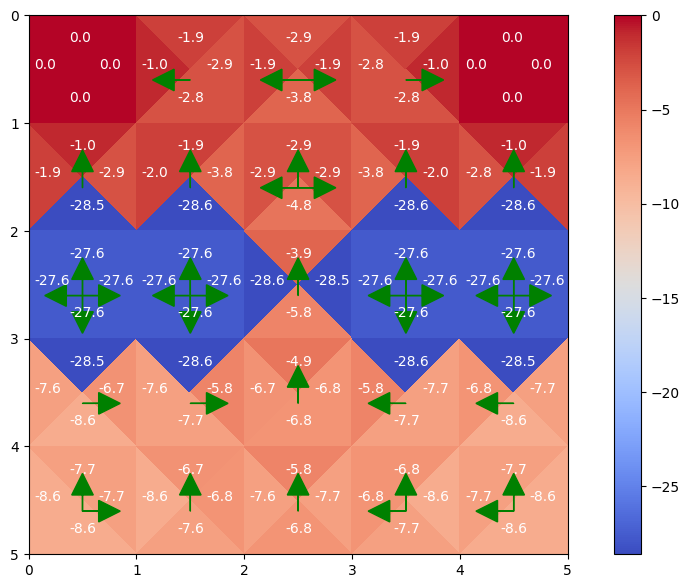

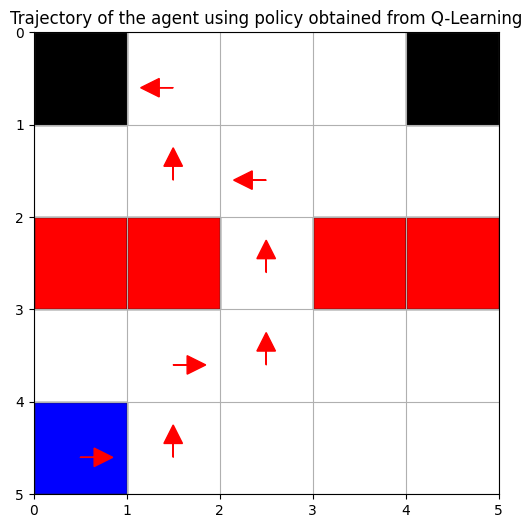

In [5]:
def qLearning(mdp, alpha, epsilon, num_episode, gamma):
    
    # initialize Q
    Q = {}
    for state in mdp.state_space:
        for action in mdp.action_space:
            if mdp.isTerminal(state):
                Q[(state, action)] = 0
            else:
                Q[(state, action)] = 10
    
    # epsilon-greedy policy
    def policy(state):
        if np.random.random() < epsilon:
            action = random.choice(mdp.action_space)
        else:
            q_values = []
            for (s, a), val in Q.items():
                if s == state:
                    q_values.append(val)
            best_action = np.argmax(q_values)
            action = mdp.action_space[best_action]
        return action
    
    total_reward = []
    for _ in range(num_episode):
        start_state = mdp.reset()
        state = start_state
        cum_reward = 0
        
        while True:
            action = policy(state)
            # action = random.choice(mdp.action_space)
            next_state, reward = mdp.nextStateReward(state, action)

            # obtain state-action values for next state
            q_next_state = []
            for (s, a), val in Q.items():
                if s == next_state:
                    q_next_state.append(val)
            
            Q_next_state = max(q_next_state)

            # update Q
            Q[(state, action)]  += round((alpha * (reward + gamma * Q_next_state - Q[(state, action)])), 1)

            # update state
            state = next_state

            # update sum of reward
            cum_reward += reward
        

            if mdp.isTerminal(state):
                break
        
        total_reward.append(cum_reward)
    
    return Q, total_reward



# implement Q-Learning off-policy TD Control
mdp = GridWorld()
gamma = 1
alpha = 0.5
epsilon = 0.2
num_epsiode = 100000

Q, reward_qlearning = qLearning(mdp= mdp,
                      alpha= alpha,
                      epsilon= epsilon,
                      num_episode= num_epsiode,
                      gamma= gamma
                      )

# obtain optimal policy from Q
policy = np.empty(mdp.gridsize, dtype= object)
for state in mdp.state_space:
    policy[state] = []

    if not mdp.isTerminal(state):
        action_values = []
        for (s,a), v in Q.items():
            if s == state:
                action_values.append(round(v, 1))
        
        best_action = np.where(np.array(action_values) == max(action_values))[0]

        for idx in best_action:
            action = mdp.action_space[idx]
            policy[state].append(action)

    
# convert Q to grid for easy visualization
action_value_grid = np.zeros((len(mdp.state_space), len(mdp.action_space)))

for i, state in enumerate(mdp.state_space):
    for j, action in enumerate(mdp.action_space): 
        value = Q[(state, action)]
        action_value_grid[(i,j)] = value

# Visualize Q and Policy
plot_action_value(mdp= mdp,
                  action_value_grid= action_value_grid,
                  plot_policy= True,
                  policy= policy
                  )  

plt.show() 

# plot the trajectory of the agent utilizing the learned policy
# policy for visited states and trajectory of visited states
policy = np.zeros(mdp.gridsize, dtype= object)
trajectory = []

# start state
state = mdp.reset()
trajectory.append(state)

while not mdp.isTerminal(state):
    action_values =[]
    for (s, a), v in Q.items():
        if s == state:
            action_values.append(v)
    # select greedy actions
    best_action = np.where(np.array(action_values) == max(action_values))[0]
    # choose any greedy action
    policy[state] = mdp.action_space[random.choice(best_action)]
    # get next state based on the action
    next_state, _  = mdp.nextStateReward(state, policy[state])
    # update state and trajectory
    state = next_state
    trajectory.append(state)

# plot the agent trajectory
ax = policyTrajectory(mdp= mdp, policy= policy, trajectory= trajectory)
ax.set_title('Trajectory of the agent using policy obtained from Q-Learning')
plt.show()

# Reward Comparison

Average of the total reward over an episode for sarsa is -24.212126
Average of the total reward over an episode for Q-learning is -16.70548


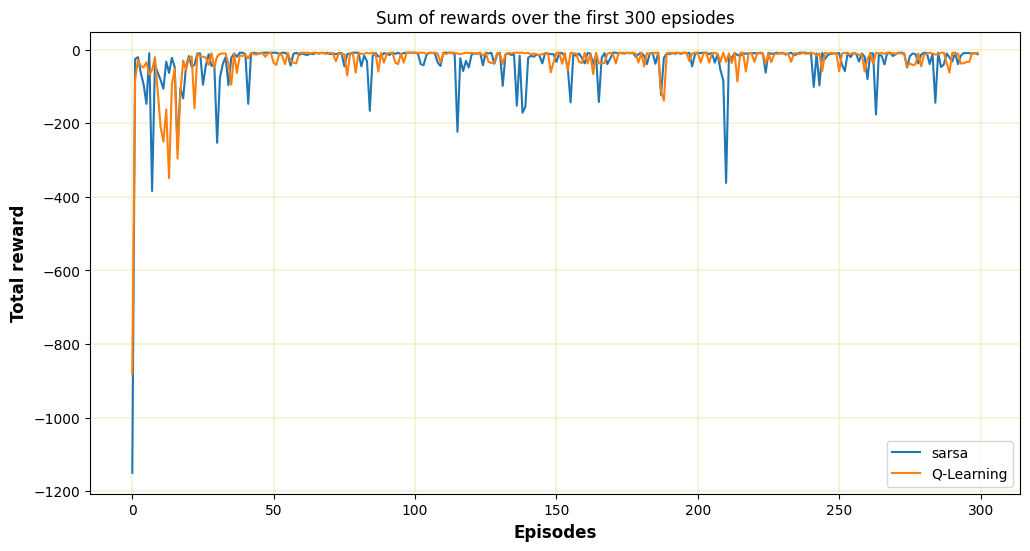

In [8]:
print('Average of the total reward over an episode for sarsa is {}'.format(np.mean(reward_sarsa)))
print('Average of the total reward over an episode for Q-learning is {}'.format(np.mean(reward_qlearning)))

# select minimum number of episodes
size = min(300, min(len(reward_qlearning), len(reward_sarsa)))

# plot reward
plt.figure(figsize= (12, 6))
plt.plot(reward_sarsa[:size], label = 'sarsa')
plt.plot(reward_qlearning[:size], label = 'Q-Learning')
plt.xlabel('Episodes', weight = 'bold', fontsize = 12)
plt.ylabel('Total reward', weight = 'bold', fontsize = 12)
plt.grid(color = 'y', linewidth = 0.2)
plt.title('Sum of rewards over the first {} epsiodes'.format(size))
plt.legend()
plt.show()

In [7]:
# Evaluation function
def evaluate_policy(mdp, Q, num_eval_episodes):
    total_rewards = []
    for episode in range(num_eval_episodes):
        state = mdp.reset()
        total_reward = 0
        while not mdp.isTerminal(state):
            action_values =[]
            for (s, a), v in Q.items():
                if s == state:
                    action_values.append(v)
            # select greedy actions
            best_action = np.where(np.array(action_values) == max(action_values))[0]
            # choose any greedy action
            policy[state] = mdp.action_space[random.choice(best_action)]
            # get next state based on the action
            next_state, reward  = mdp.nextStateReward(state, policy[state])
            # update state and total reward
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    return total_rewards